In [1]:
#import libraries
import os
import sys

import numpy as np
import csv
import pandas as pd
from random import shuffle
#import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
from torchvision import models
from torch.nn import init
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import f1_score   
    

from tqdm import tqdm, tqdm_notebook, tnrange
from tqdm.autonotebook import tqdm
import logging

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ch = logging.StreamHandler(sys.stdout)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
#importing "model_outputs_patient_level_v1" dataset
dataset = pd.read_csv('model_outputs_patient_level_v1.csv')

In [4]:
#importing "model_outputs_patient_level_original_images" dataset
dataset2 = pd.read_csv('model_outputs_patient_level_original_images.csv')

In [4]:
#importing "model_outputs_v1" dataset
dataset3 = pd.read_csv('model_outputs_v1.csv')

In [4]:
#importing "model_outputs_v1" dataset
# cols = d_dx,d_age, d_gender, d_vacc_st, d_race, v_temperature, v_cough, s_antipy, s_odynop, s_dyspha, t_rtpcr, t_ag 
dataset4 = pd.read_csv('data_train.csv')

In [5]:
#partial view of dataset from top
dataset.head()

,patient_id,bacterial_score,covid_score,normal_score,prediction,target,group
0,R_0dE4arEYyn9VJOV,-0.314141,-0.064040,0.326980,normal,covid,train
1,R_10vi04lh64FGSvp,-3.149383,-0.104033,4.250199,normal,normal,train
2,R_114rz6JiHw1akAz,-4.287257,7.185577,-2.219140,covid,covid,train
3,R_12JQheYe68Gad2a,-0.930601,-0.562607,2.240499,normal,normal,train
4,R_1CwPCqYEGxeiu3r,-3.412590,5.565616,-1.503724,covid,covid,train


In [68]:
#importing "model_outputs_patient_level_original_images" dataset
dataset2.head()

,patient_id,bacterial_score,covid_score,normal_score,prediction,target,group
0,R_0dE4arEYyn9VJOV,-1.030798,0.062354,0.884061,normal,covid,train
1,R_10vi04lh64FGSvp,-2.658519,0.728304,3.154019,normal,normal,val
2,R_114rz6JiHw1akAz,-4.300032,6.399438,-1.515726,covid,covid,train
3,R_12JQheYe68Gad2a,-0.115888,-1.111808,2.172140,normal,normal,train
4,R_1CwPCqYEGxeiu3r,-3.764262,5.037803,-0.691761,covid,covid,train


In [69]:
#importing "model_outputs_v1" dataset
dataset3.head()

,Unnamed: 0,path,bacterial_score,covid_score,normal_score,final_pred,target
0,0,/workspace/train/bacterial/R_1Nku5oxjalz9Req_6...,3.142349,-1.737897,-1.409055,bacterial,bacterial
1,1,/workspace/train/normal/R_2YzxU8PRG67wpiX_8jnt...,-0.528219,-1.249070,2.214347,normal,normal
2,2,/workspace/train/normal/R_3I5fyXtmCgzo5vR_23rg...,-2.220900,-1.116497,4.142112,normal,normal
3,3,/workspace/train/bacterial/R_2a9MExLd13dgPFE_3...,1.585770,-0.515475,-0.806579,bacterial,bacterial
4,4,/workspace/train/normal/R_1ouNSYTmyoPQ4ZE_1646...,-3.546503,0.936252,3.608383,normal,normal


In [5]:
# main dataset metadata
dataset4.head()

,d_dx,ResponseId,d_age,d_gender,d_vacc_status,d_race,v_temperature,v_cough,s_antipyretic,s_odynophagia,...,t_med_iantiviral,t_med_insulin,t_med_insuline,t_med_losartan,t_med_nan,t_med_none,t_med_omeprazole,t_med_retroviral,t_med_telmisartan,t_med_troferit
0,bacterial,R_3MrigfEmDAx3Ucm,26,0,0,White,100.2,Wet,1,1,...,0,0,0,0,1,0,0,0,0,0
1,covid,R_32QmzEehlIFCqgd,58,1,0,Other,98.2,Dry,1,2,...,0,0,1,1,0,0,0,0,0,1
2,normal,R_UgAqBPzsz0PRYpH,28,1,0,Other,97.9,None,0,0,...,0,0,0,0,1,0,0,0,0,0
3,bacterial,R_3PpEu0aTlws6NsO,58,0,0,Other,100.8,Dry,1,3,...,0,0,0,0,1,0,0,0,0,0
4,normal,R_1ouNSYTmyoPQ4ZE,45,1,3,Hispanic,97.7,None,0,0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
#checking for missing values
print(str('Any missing data or NaN in the dataset:'),dataset.isnull().values.any())

Any missing data or NaN in the dataset: False


In [7]:
dataset = dataset[['bacterial_score','covid_score','normal_score','target']]

In [6]:
dataset2 = dataset2[['bacterial_score','covid_score','normal_score','target']]

In [5]:
dataset3 = dataset3[['bacterial_score','covid_score','normal_score','target']]

In [8]:
# colums to include for data_train
# one-hot columns are (v_cough, t_rtpcr, t_ag)
dataset4 = dataset4[['d_dx', 'd_age', 'd_gender', 'd_vacc_status', 'v_temperature', 'v_cough', 's_antipyretic', 's_antipyretic', 's_odynophagia', 's_dysphagia', 't_rtpcr', 't_ag']]

In [9]:
#partial view of dataset from top
dataset3.head()

NameError: name 'dataset3' is not defined

In [10]:
dataset4.head()

,d_dx,d_age,d_gender,d_vacc_status,v_temperature,v_cough,s_antipyretic,s_antipyretic,s_antipyretic,s_antipyretic,s_odynophagia,s_dysphagia,t_rtpcr,t_ag
0,bacterial,26,0,0,100.2,Wet,1,1,1,1,1,1,Not taken,Not taken
1,covid,58,1,0,98.2,Dry,1,1,1,1,2,2,Positive,Pending
2,normal,28,1,0,97.9,None,0,0,0,0,0,0,Not taken,Not taken
3,bacterial,58,0,0,100.8,Dry,1,1,1,1,3,3,Not taken,Not taken
4,normal,45,1,3,97.7,None,0,0,0,0,0,0,Not taken,Not taken


In [8]:
dataset4.shape

(104, 12)

In [11]:

X = dataset4.iloc[:, 1:12].values
y = dataset4.iloc[:, 0].values

In [13]:
print(y)

['bacterial' 'covid' 'normal' 'bacterial' 'normal' 'normal' 'bacterial'
 'covid' 'bacterial' 'covid' 'bacterial' 'bacterial' 'normal' 'bacterial'
 'bacterial' 'bacterial' 'normal' 'covid' 'covid' 'normal' 'normal'
 'bacterial' 'covid' 'bacterial' 'normal' 'covid' 'bacterial' 'bacterial'
 'bacterial' 'normal' 'covid' 'bacterial' 'bacterial' 'normal' 'normal'
 'covid' 'normal' 'bacterial' 'bacterial' 'covid' 'bacterial' 'normal'
 'normal' 'covid' 'normal' 'normal' 'normal' 'normal' 'normal' 'covid'
 'normal' 'covid' 'bacterial' 'covid' 'bacterial' 'normal' 'bacterial'
 'covid' 'normal' 'normal' 'normal' 'normal' 'normal' 'bacterial' 'covid'
 'covid' 'bacterial' 'covid' 'bacterial' 'covid' 'normal' 'normal'
 'normal' 'bacterial' 'covid' 'bacterial' 'bacterial' 'bacterial' 'normal'
 'covid' 'covid' 'covid' 'bacterial' 'normal' 'bacterial' 'normal'
 'normal' 'bacterial' 'normal' 'normal' 'bacterial' 'normal' 'normal'
 'bacterial' 'bacterial' 'normal' 'bacterial' 'bacterial' 'bacterial'
 'co

In [9]:
print(X)

[[26 0 0 ... 1 'Not taken' 'Not taken']
 [58 1 0 ... 2 'Positive' 'Pending']
 [28 1 0 ... 0 'Not taken' 'Not taken']
 ...
 [36 0 0 ... 0 'Pending' 'Not taken']
 [36 1 0 ... 0 'Not taken' 'Not taken']
 [34 0 0 ... 0 'Not taken' 'Not taken']]


In [12]:
#country name wont be that much correlation added it has more than 2 names so go for one hot encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
#country name is present in 1st index value
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [6, 9, 10])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [23]:
print(X)

[[0.0 1.0 1.0 ... 1 1 1]
 [1.0 0.0 0.0 ... 1 2 2]
 [0.0 1.0 0.0 ... 0 0 0]
 ...
 [0.0 1.0 1.0 ... 0 0 0]
 [0.0 1.0 0.0 ... 0 0 0]
 [0.0 1.0 1.0 ... 1 0 0]]


                  d_age  d_gender  d_vacc_status  v_temperature  \
d_age          1.000000 -0.175032       0.174134      -0.113888   
d_gender      -0.175032  1.000000       0.100019       0.007441   
d_vacc_status  0.174134  0.100019       1.000000      -0.333652   
v_temperature -0.113888  0.007441      -0.333652       1.000000   
s_antipyretic  0.267337 -0.120985      -0.110441       0.422656   
s_antipyretic  0.267337 -0.120985      -0.110441       0.422656   
s_odynophagia -0.060745  0.044586      -0.272559       0.677142   
s_dysphagia   -0.034078 -0.022305      -0.267770       0.651932   

               s_antipyretic  s_antipyretic  s_odynophagia  s_dysphagia  
d_age               0.267337       0.267337      -0.060745    -0.034078  
d_gender           -0.120985      -0.120985       0.044586    -0.022305  
d_vacc_status      -0.110441      -0.110441      -0.272559    -0.267770  
v_temperature       0.422656       0.422656       0.677142     0.651932  
s_antipyretic       1.0000

<AxesSubplot:>

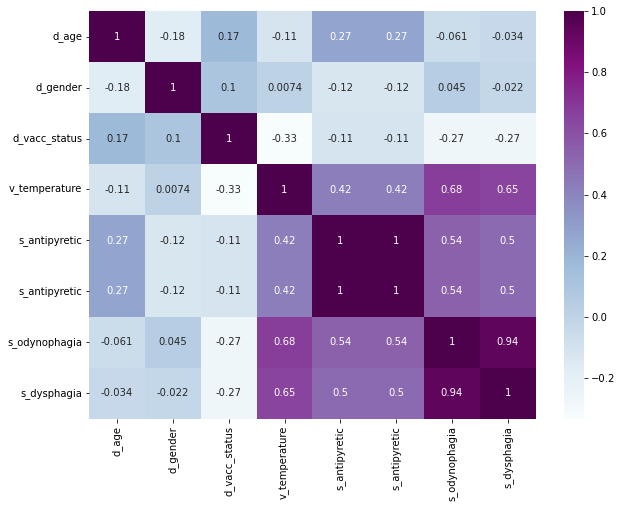

In [14]:
#finding correlation between the features
corr_var=dataset4.corr()
print(corr_var)
plt.figure(figsize=(10,7.5))
sns.heatmap(corr_var, annot=True, cmap='BuPu')

In [10]:
#dimension of the dataset
dataset.shape

(126, 4)

In [7]:
dataset2.shape

(123, 4)

In [7]:
dataset3.shape

(172, 4)

In [12]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

In [8]:
X = dataset2.iloc[:, 0:-1].values
y = dataset2.iloc[:, -1].values

In [8]:
X = dataset3.iloc[:, 0:-1].values
y = dataset3.iloc[:, -1].values

In [16]:
print(X)

[[0.0 1.0 0.0 ... 1 1 1]
 [0.0 1.0 0.0 ... 1 1 1]
 [1.0 0.0 1.0 ... 0 0 0]
 ...
 [1.0 0.0 1.0 ... 0 0 0]
 [1.0 0.0 1.0 ... 0 0 0]
 [0.0 1.0 1.0 ... 1 1 1]]


In [17]:
type(X)

numpy.ndarray

In [10]:
print(y)

['covid' 'normal' 'covid' 'normal' 'covid' 'normal' 'covid' 'bacterial'
 'bacterial' 'normal' 'bacterial' 'covid' 'bacterial' 'bacterial' 'normal'
 'bacterial' 'normal' 'bacterial' 'normal' 'covid' 'covid' 'bacterial'
 'bacterial' 'normal' 'normal' 'normal' 'covid' 'bacterial' 'bacterial'
 'covid' 'covid' 'bacterial' 'normal' 'bacterial' 'bacterial' 'normal'
 'normal' 'covid' 'covid' 'normal' 'normal' 'normal' 'normal' 'normal'
 'normal' 'normal' 'bacterial' 'normal' 'normal' 'normal' 'covid' 'normal'
 'bacterial' 'covid' 'normal' 'normal' 'covid' 'normal' 'covid' 'normal'
 'bacterial' 'bacterial' 'bacterial' 'bacterial' 'normal' 'bacterial'
 'bacterial' 'bacterial' 'normal' 'bacterial' 'normal' 'bacterial'
 'normal' 'normal' 'covid' 'normal' 'normal' 'bacterial' 'bacterial'
 'covid' 'covid' 'bacterial' 'bacterial' 'bacterial' 'covid' 'normal'
 'normal' 'covid' 'covid' 'normal' 'covid' 'normal' 'bacterial' 'covid'
 'covid' 'covid' 'normal' 'bacterial' 'normal' 'covid' 'bacterial' 'covi

In [13]:
#Categorical encoding for the target
#from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y[:] = le.fit_transform(y[:])

In [17]:
type(y)

numpy.ndarray

In [18]:
print(y)

[0 1 2 0 2 2 0 1 0 1 0 0 2 0 0 0 2 1 1 2 2 0 1 0 2 1 0 0 0 2 1 0 0 2 2 1 2
 0 0 1 0 2 2 1 2 2 2 2 2 1 2 1 0 1 0 2 0 1 2 2 2 2 2 0 1 1 0 1 0 1 2 2 2 0
 1 0 0 0 2 1 1 1 0 2 0 2 2 0 2 2 0 2 2 0 0 2 0 0 0 1 2 1 2 0]


In [18]:
type(X)

numpy.ndarray

In [15]:
#country name wont be that much correlation added it has more than 2 names so go for one hot encoding
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import OneHotEncoder
#country name is present in 1st index value
#ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
#X = np.array(ct.fit_transform(X))

In [14]:
#training and testing split function
# Will use this to split into train and validate this time
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [21]:
print(X)

[[0.0 1.0 0.0 ... 1 1 1]
 [0.0 0.0 0.0 ... 1 2 2]
 [0.0 1.0 0.0 ... 0 0 0]
 ...
 [0.0 0.0 1.0 ... 0 0 0]
 [0.0 1.0 0.0 ... 0 0 0]
 [0.0 1.0 0.0 ... 1 0 0]]


In [15]:
#feature scaling is an important and mandatory for ann process before modelling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

ValueError: could not convert string to float: 'None'

In [16]:
print(y)

[1 2 1 2 1 2 1 0 0 2 0 1 0 0 2 0 2 0 2 1 1 0 0 2 2 2 1 0 0 1 1 0 2 0 0 2 2
 1 1 2 2 2 2 2 2 2 0 2 2 2 1 2 0 1 2 2 1 2 1 2 0 0 0 0 2 0 0 0 2 0 2 0 2 2
 1 2 2 0 0 1 1 0 0 0 1 2 2 1 1 2 1 2 0 1 1 1 2 0 2 1 0 1 0 2 2 0 0 0 1 2 1
 0 0 2 0 2 2 0 0 2 2 2 1]


In [22]:
#y = np.array(y, dtype=np.float16)

In [23]:
print(y)

[1 2 1 2 1 2 1 0 0 2 0 1 0 0 2 0 2 0 2 1 1 0 0 2 2 2 1 0 0 1 1 0 2 0 0 2 2
 1 1 2 2 2 2 2 2 2 0 2 2 2 1 2 0 1 2 2 1 2 2 1 2 0 0 0 0 2 0 0 0 2 0 2 0 2
 2 1 2 2 0 0 1 1 0 0 0 1 2 2 1 1 2 1 2 0 1 1 1 2 0 2 1 0 1 0 2 2 0 0 0 1 2
 1 0 2 0 2 0 2 2 0 0 2 2 2 2 1]


In [13]:
print('Train data set:', len(X_train))
print('Validation data set:', len(X_val))

Train data set: 120
Validation data set: 52


In [25]:
print(X)

[[-3.1414120e-01 -6.4040326e-02  3.2697980e-01]
 [-3.1493835e+00 -1.0403266e-01  4.2501993e+00]
 [-4.2872567e+00  7.1855774e+00 -2.2191403e+00]
 [-9.3060124e-01 -5.6260693e-01  2.2404993e+00]
 [-3.4125898e+00  5.5656160e+00 -1.5037245e+00]
 [-1.1502687e+00 -8.9617735e-01  2.1934068e+00]
 [-3.5938250e+00  6.1282954e+00 -2.0727468e+00]
 [ 3.0500658e+00 -7.6074280e-01 -1.6272633e+00]
 [ 4.7408905e+00 -1.1547126e+00 -3.1440196e+00]
 [-3.1859577e-01 -1.4221884e+00  2.4021032e+00]
 [ 2.9879577e+00 -1.9077753e+00 -7.9448783e-01]
 [ 1.3221179e+00 -4.5873990e-01 -6.7501070e-01]
 [ 5.4516140e-01 -6.2160400e-01  5.1225716e-01]
 [ 2.9751408e+00 -1.7096481e+00 -1.4888082e+00]
 [ 4.2601126e-01 -1.3782760e-01 -2.5847560e-02]
 [ 2.7337341e+00 -1.3899528e+00 -1.3001254e+00]
 [ 1.2680313e-01 -4.9600005e-01  6.4611370e-01]
 [ 2.8943640e+00 -1.2893875e+00 -8.7796736e-01]
 [-1.1878661e+00 -1.0804182e+00  2.8887990e+00]
 [-4.4728380e+00  6.5762170e+00 -1.7032211e+00]
 [-4.1937523e+00  6.3218856e+00 -1.39966

In [26]:
print(y)

[1 2 1 2 1 2 1 0 0 2 0 1 0 0 2 0 2 0 2 1 1 0 0 2 2 2 1 0 0 1 1 0 2 0 0 2 2
 1 1 2 2 2 2 2 2 2 0 2 2 2 1 2 0 1 2 2 1 2 2 1 2 0 0 0 0 2 0 0 0 2 0 2 0 2
 2 1 2 2 0 0 1 1 0 0 0 1 2 2 1 1 2 1 2 0 1 1 1 2 0 2 1 0 1 0 2 2 0 0 0 1 2
 1 0 2 0 2 0 2 2 0 0 2 2 2 2 1]


In [27]:
type(y)

numpy.ndarray

In [14]:
# Write a dataloader
class table_loader(Dataset):
    def __init__(self, X, y, batchsize = 50, shuffleidx = False):
        self.X, self.y = X, y
        if shuffleidx:
          self.X, self.y = self.shuffle(self.X, self.y)
        self.batch_size = batchsize

    def __len__(self):
        return (self.X.shape[0] // self.batch_size) + 1

    def __getitem__(self, idx):

        # Create the batch input and target
        batchidx = slice(idx*self.batch_size, (idx+1)*self.batch_size)
        x = self.X[batchidx]
        y = self.y[batchidx]

        # Move the data to dtype float and onto the device
        x = torch.from_numpy(x).float().to(device)
        y = np.array(y, dtype=np.int64)
           # torch.from_numpy(df).float().to(device)
        y = torch.from_numpy(y).float().to(device)

        return x, y
      
    def shuffle(self, X, y):
        indices = np.arange(X_train.shape[0]) #gets the number of rows 
        shuffle(indices)
        Xout, yout = X[list(indices)], y[list(indices)]
        return Xout, yout

In [15]:
class LogisticRegresion(nn.Module):
    def __init__(self, input_dim = 6, output_dim = 6):
        super(LogisticRegresion, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.linear2 = nn.Linear(6, 6)
        self.linear3 = nn.Linear(6, 1)
        self.m = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.m(x)
        x = x.flatten()
        return x

In [16]:
model = LogisticRegresion(input_dim = X_train.shape[1])

In [17]:
batch_size = 1024
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.BCELoss()
device = 'cuda'
model = model.to(device)

In [18]:
trndataset = table_loader(X_train, y_train, batch_size, shuffleidx = True)
valdataset = table_loader(X_val, y_val, batch_size, shuffleidx = False)

In [19]:
for epoch in range(100):
  # Training step
  trn_losses = []
  pbartrn = tqdm(range(len(trndataset)), total = len(trndataset))
  model.train()
  for step in pbartrn: 
    optimizer.zero_grad() # Zero gradients each step 
    # Run through the model, get the loss and make a gradient descent step
    (x,y) = trndataset.__getitem__(step)
    out = model(x)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    trn_losses.append(loss.item())
    pbartrn.set_description(f'Epoch {epoch} train loss: {sum(trn_losses)/(1+step) :.4f}')

  # Validation step
  pbarval = tqdm(range(len(valdataset)), total = len(valdataset))
  model.eval()
  val_losses = []
  preds = []
  for step in pbarval: 
    # Run through the model, get the loss; note, we do not need gradients during inference
    (x,y) = valdataset.__getitem__(step)
    with torch.no_grad():
      out = model(x)
    preds.append(out.detach().cpu())
    loss = criterion(out, y)
    val_losses.append(loss.item())
    pbarval.set_description(f'Epoch {epoch} valid loss: {sum(val_losses)/(1+step) :.4f}')

  y_pred = np.concatenate(preds)

  # printing the valid auc causes the code to produce an error
  #print(f'Epoch {epoch} valid auc : {roc_auc_score(y_val, y_pred):.4f}')
  #print(f'Epoch {epoch} valid f1 : {f1_score(y_val, y_pred):.4f}')
  print(f'Epoch {epoch} valid accuracy : {y_pred.mean() * 100:f}')
  

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0 valid accuracy : 50.034255


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 valid accuracy : 52.038670


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2 valid accuracy : 53.977978


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3 valid accuracy : 55.843741


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4 valid accuracy : 57.628667


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5 valid accuracy : 59.327632


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6 valid accuracy : 60.937107


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7 valid accuracy : 62.453687


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8 valid accuracy : 63.873798


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9 valid accuracy : 65.194511


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10 valid accuracy : 66.413373


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11 valid accuracy : 67.527783


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12 valid accuracy : 68.534988


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13 valid accuracy : 69.434464


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14 valid accuracy : 70.228565


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15 valid accuracy : 70.921201


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16 valid accuracy : 71.517289


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17 valid accuracy : 72.022283


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18 valid accuracy : 72.442031


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19 valid accuracy : 72.782397


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20 valid accuracy : 73.048961


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21 valid accuracy : 73.246777


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22 valid accuracy : 73.380214


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23 valid accuracy : 73.453009


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24 valid accuracy : 73.468590


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25 valid accuracy : 73.430437


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26 valid accuracy : 73.342574


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27 valid accuracy : 73.210388


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28 valid accuracy : 73.041844


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29 valid accuracy : 72.848850


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30 valid accuracy : 72.648585


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31 valid accuracy : 72.461861


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32 valid accuracy : 72.306478


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33 valid accuracy : 72.188765


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34 valid accuracy : 72.179615


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35 valid accuracy : 72.291797


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36 valid accuracy : 72.561163


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37 valid accuracy : 72.895181


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38 valid accuracy : 73.175216


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39 valid accuracy : 73.366797


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40 valid accuracy : 73.573601


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41 valid accuracy : 73.791724


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42 valid accuracy : 73.959857


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43 valid accuracy : 74.053234


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44 valid accuracy : 74.217027


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45 valid accuracy : 74.415803


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46 valid accuracy : 74.816364


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47 valid accuracy : 75.313705


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48 valid accuracy : 76.010036


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49 valid accuracy : 76.878899


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 50 valid accuracy : 77.828795


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 51 valid accuracy : 78.762162


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 52 valid accuracy : 79.581696


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 53 valid accuracy : 80.228174


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 54 valid accuracy : 80.688101


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 55 valid accuracy : 80.977124


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 56 valid accuracy : 81.145757


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 57 valid accuracy : 81.238991


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 58 valid accuracy : 81.293958


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 59 valid accuracy : 81.334043


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 60 valid accuracy : 81.368166


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 61 valid accuracy : 81.402361


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 62 valid accuracy : 81.439739


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 63 valid accuracy : 81.481653


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 64 valid accuracy : 81.528503


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 65 valid accuracy : 81.576377


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 66 valid accuracy : 81.624788


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 67 valid accuracy : 81.667668


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 68 valid accuracy : 81.704617


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 69 valid accuracy : 81.735408


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 70 valid accuracy : 81.759965


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 71 valid accuracy : 81.778425


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 72 valid accuracy : 81.791019


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 73 valid accuracy : 81.798089


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 74 valid accuracy : 81.800085


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 75 valid accuracy : 81.797481


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 76 valid accuracy : 81.790841


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 77 valid accuracy : 81.780756


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 78 valid accuracy : 81.767851


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 79 valid accuracy : 81.752753


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 80 valid accuracy : 81.736094


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 81 valid accuracy : 81.718528


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 82 valid accuracy : 81.700683


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 83 valid accuracy : 81.675905


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 84 valid accuracy : 81.645578


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 85 valid accuracy : 81.611103


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 86 valid accuracy : 81.574070


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 87 valid accuracy : 81.536013


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 88 valid accuracy : 81.498438


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 89 valid accuracy : 81.462735


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 90 valid accuracy : 81.430095


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 91 valid accuracy : 81.401503


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 92 valid accuracy : 81.377655


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 93 valid accuracy : 81.359029


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 94 valid accuracy : 81.345886


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 95 valid accuracy : 81.338280


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 96 valid accuracy : 81.336111


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 97 valid accuracy : 81.339145


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 98 valid accuracy : 81.347042


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 99 valid accuracy : 81.359315
